In [44]:
# Cell 1: Imports & Setup
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import qlib
from qlib.data import D
from qlib.config import REG_CN

# ML imports
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.neural_network import MLPClassifier

# Styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("Libraries imported successfully")


Libraries imported successfully


In [45]:
# Cell 2: Configuration - Optimized for Quality over Quantity
# Data configuration
DATA_PATH = r"X:/QuantumTickAI/trading-lab/data/raw/qlib_data"
SYMBOL = "AAPL"
BENCHMARK = "SPY"
START_DATE = "2010-01-01"
END_DATE = "2020-11-10"

# Trading parameters
TRANSACTION_COST = 0.001  # 10 basis points
EMA_SHORT = 50
EMA_LONG = 200

# Refined ML parameters for higher quality signals
N_FEATURES = 15
TARGET_RETURN = 0.05  # Increased to 1.5% for more significant moves
FORWARD_DAYS = 10       # Increased to 5 days to capture medium-term momentum
ML_BUY_THRESHOLD = 0.6  # High ML confidence required for a buy signal (Adjusted for more buy signals)
ML_SELL_THRESHOLD = 0.4 # Low ML confidence used as an aggressive sell signal (Adjusted for more sell signals)
LSTM_LOOKBACK = 20     # Days to look back for sequence modeling - No longer used, but kept for context
ENSEMBLE_WEIGHT_DL = 0.4   # Weight for deep learning vs traditional ML - Now unused, but kept for context

print(f"Configuration set for ML-Guided Hybrid Strategy")
print(f"Target: {TARGET_RETURN:.1%} return over {FORWARD_DAYS} days")
print(f"Using a Gradient Boosting Model instead of a Deep Learning Model")


Configuration set for ML-Guided Hybrid Strategy
Target: 5.0% return over 10 days
Using a Gradient Boosting Model instead of a Deep Learning Model


In [46]:
# Cell 3: Data Loading & Feature Engineering
# Initialize qlib
qlib.init(provider_uri=DATA_PATH, region=REG_CN)

# Load basic price data
instruments = [SYMBOL, BENCHMARK]
fields = ["$open", "$high", "$low", "$close", "$volume"]

data = D.features(instruments, fields, start_time=START_DATE, end_time=END_DATE)
data = data.reset_index()
data.columns = ['instrument', 'datetime', 'open', 'high', 'low', 'close', 'volume']

# Create comprehensive technical features similar to Alpha158
def create_technical_features(df):
    """Create comprehensive technical indicators similar to Alpha158"""
    features = pd.DataFrame(index=df.index)

    # Price features
    features['returns_1d'] = df['close'].pct_change(1)
    features['returns_5d'] = df['close'].pct_change(5)
    features['returns_10d'] = df['close'].pct_change(10)
    features['returns_20d'] = df['close'].pct_change(20)

    # Moving averages
    for period in [5, 10, 20, 30, 60]:
        features[f'ma_{period}'] = df['close'].rolling(period).mean()
        features[f'ma_ratio_{period}'] = df['close'] / features[f'ma_{period}'] - 1

    # Volatility features
    for period in [5, 10, 20]:
        features[f'std_{period}'] = df['close'].pct_change().rolling(period).std()

    # Volume features
    features['volume_ratio'] = df['volume'] / df['volume'].rolling(20).mean()
    features['price_volume'] = df['close'] * df['volume']

    # Technical indicators
    # RSI
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    features['rsi'] = 100 - (100 / (1 + gain / loss))

    # MACD
    exp1 = df['close'].ewm(span=12, adjust=False).mean()
    exp2 = df['close'].ewm(span=26, adjust=False).mean()
    features['macd'] = exp1 - exp2
    features['macd_signal'] = features['macd'].ewm(span=9, adjust=False).mean()

    # Bollinger Bands
    bb_period = 20
    bb_std = 2
    bb_ma = df['close'].rolling(bb_period).mean()
    bb_std_dev = df['close'].rolling(bb_period).std()
    features['bb_upper'] = bb_ma + (bb_std_dev * bb_std)
    features['bb_lower'] = bb_ma - (bb_std_dev * bb_std)
    features['bb_position'] = (df['close'] - features['bb_lower']) / (features['bb_upper'] - features['bb_lower'])

    # High-Low features
    features['high_low_ratio'] = df['high'] / df['low']
    features['close_high_ratio'] = df['close'] / df['high']
    features['close_low_ratio'] = df['close'] / df['low']

    # Momentum indicators
    for period in [5, 10, 20]:
        features[f'momentum_{period}'] = df['close'] / df['close'].shift(period)
        features[f'high_max_{period}'] = df['high'].rolling(period).max()
        features[f'low_min_{period}'] = df['low'].rolling(period).min()
        features[f'position_{period}'] = (df['close'] - features[f'low_min_{period}']) / (features[f'high_max_{period}'] - features[f'low_min_{period}'])

    # Cross-sectional features (rank-based)
    features['volume_rank_20'] = df['volume'].rolling(20).rank(pct=True)
    features['return_rank_20'] = features['returns_1d'].rolling(20).rank(pct=True)
    
    return features

# Filter AAPL and SPY data
aapl_data = data[data['instrument'] == SYMBOL].copy().sort_values('datetime').reset_index(drop=True)
spy_data = data[data['instrument'] == BENCHMARK].copy().sort_values('datetime').reset_index(drop=True)

# Generate technical features for AAPL
alpha158_data = create_technical_features(aapl_data)
alpha158_data['datetime'] = aapl_data['datetime']

print(f"Loaded {len(aapl_data)} trading days")
print(f"Technical features shape: {alpha158_data.shape}")
print(f"Generated {alpha158_data.shape[1]-1} technical indicators")

[3800:MainThread](2025-09-26 10:39:47,307) INFO - qlib.Initialization - [config.py:452] - default_conf: client.
[3800:MainThread](2025-09-26 10:39:47,310) INFO - qlib.Initialization - [__init__.py:75] - qlib successfully initialized based on client settings.
[3800:MainThread](2025-09-26 10:39:47,310) INFO - qlib.Initialization - [__init__.py:77] - data_path={'__DEFAULT_FREQ': WindowsPath('X:/QuantumTickAI/trading-lab/data/raw/qlib_data')}


Loaded 2734 trading days
Technical features shape: (2734, 43)
Generated 42 technical indicators


In [47]:
# Cell 4: Traditional Signals - Golden Cross
def calculate_ema(series, period):
    return series.ewm(span=period, adjust=False).mean()

# Calculate EMAs
aapl_data = aapl_data.sort_values('datetime').reset_index(drop=True)
aapl_data['ema_short'] = calculate_ema(aapl_data['close'], EMA_SHORT)
aapl_data['ema_long'] = calculate_ema(aapl_data['close'], EMA_LONG)

# Golden Cross signals
aapl_data['ema_diff'] = aapl_data['ema_short'] - aapl_data['ema_long']
aapl_data['ema_diff_prev'] = aapl_data['ema_diff'].shift(1)

# Signal generation
aapl_data['golden_cross'] = 0
aapl_data.loc[(aapl_data['ema_diff'] > 0) & (aapl_data['ema_diff_prev'] <= 0), 'golden_cross'] = 1  # Buy
aapl_data.loc[(aapl_data['ema_diff'] < 0) & (aapl_data['ema_diff_prev'] >= 0), 'golden_cross'] = -1  # Sell

# Remove NaN values
aapl_data = aapl_data.dropna().reset_index(drop=True)

golden_signals = aapl_data[aapl_data['golden_cross'] != 0]
print(f"Golden Cross signals generated: {len(golden_signals)} total")
print(f"Buy signals: {len(golden_signals[golden_signals['golden_cross'] == 1])}")
print(f"Sell signals: {len(golden_signals[golden_signals['golden_cross'] == -1])}")


Golden Cross signals generated: 11 total
Buy signals: 6
Sell signals: 5


In [48]:
# Cell 5: ML Feature Preparation
# Merge technical features with price data
alpha158_data['datetime'] = pd.to_datetime(alpha158_data['datetime'])
aapl_data['datetime'] = pd.to_datetime(aapl_data['datetime'])

ml_data = aapl_data.merge(alpha158_data, on='datetime', how='inner')

# Create target variable (forward returns > TARGET_RETURN)
ml_data['forward_return'] = ml_data['close'].shift(-FORWARD_DAYS) / ml_data['close'] - 1
ml_data['target'] = (ml_data['forward_return'] > TARGET_RETURN).astype(int)

# Prepare features (exclude datetime, string columns, and target-related columns)
exclude_cols = ['instrument', 'datetime', 'open', 'high', 'low', 'close', 'volume', 'forward_return', 'target']
feature_cols = [col for col in ml_data.columns if col not in exclude_cols]

# Select only numeric features
ml_features = ml_data[feature_cols].select_dtypes(include=[np.number]).copy()

# Clean features
ml_features = ml_features.replace([np.inf, -np.inf], np.nan)
ml_features = ml_features.fillna(method='ffill').fillna(method='bfill')
ml_features = ml_features.fillna(0)  # Final fallback

# Remove last rows without target
valid_idx = ~ml_data['target'].isna()
ml_features = ml_features[valid_idx]
targets = ml_data['target'][valid_idx]

print(f"ML dataset prepared: {ml_features.shape[0]} samples, {ml_features.shape[1]} features")
print(f"Target distribution: {targets.value_counts().to_dict()}")
print(f"Feature columns: {list(ml_features.columns[:10])}...")  # Show first 10 features

ML dataset prepared: 2733 samples, 47 features
Target distribution: {0: 2110, 1: 623}
Feature columns: ['ema_short', 'ema_long', 'ema_diff', 'ema_diff_prev', 'golden_cross', 'returns_1d', 'returns_5d', 'returns_10d', 'returns_20d', 'ma_5']...


In [49]:
# Cell 6: ML Training with Scikit-learn Models
# Feature selection
selector = SelectKBest(score_func=f_classif, k=N_FEATURES)
X_selected = selector.fit_transform(ml_features, targets)
selected_features = ml_features.columns[selector.get_support()]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, targets, test_size=0.2, random_state=42, stratify=targets
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Traditional ML models
models = {}

# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, 
                           random_state=42, n_jobs=-1, class_weight='balanced')
rf.fit(X_train_scaled, y_train)
models['RandomForest'] = rf

# XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                             random_state=42, eval_metric='logloss', scale_pos_weight=1)
xgb_model.fit(X_train_scaled, y_train)
models['XGBoost'] = xgb_model

# Logistic Regression
lr = LogisticRegression(random_state=42, max_iter=2000, C=1.0, class_weight='balanced')
lr.fit(X_train_scaled, y_train)
models['LogisticRegression'] = lr

# Neural Network
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42,
                   learning_rate='adaptive', alpha=0.001)
mlp.fit(X_train_scaled, y_train)
models['NeuralNetwork'] = mlp

# Gradient Boosting (replacing the old SequenceNet)
gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, subsample=0.7, random_state=42)
gb_model.fit(X_train_scaled, y_train)
models['GradientBoosting'] = gb_model

# Model performance
print("\nML Model Performance on Test Set:")
for name, model in models.items():
    if name not in ['scaler', 'selector']:
        test_score = model.score(X_test_scaled, y_test)
        print(f"{name:>20} - Test: {test_score:.4f}")

# Store scalers and selector for later use
models['scaler'] = scaler
models['selector'] = selector


ML Model Performance on Test Set:
        RandomForest - Test: 0.8903
             XGBoost - Test: 0.8629
  LogisticRegression - Test: 0.5814
       NeuralNetwork - Test: 0.7678
    GradientBoosting - Test: 0.8775


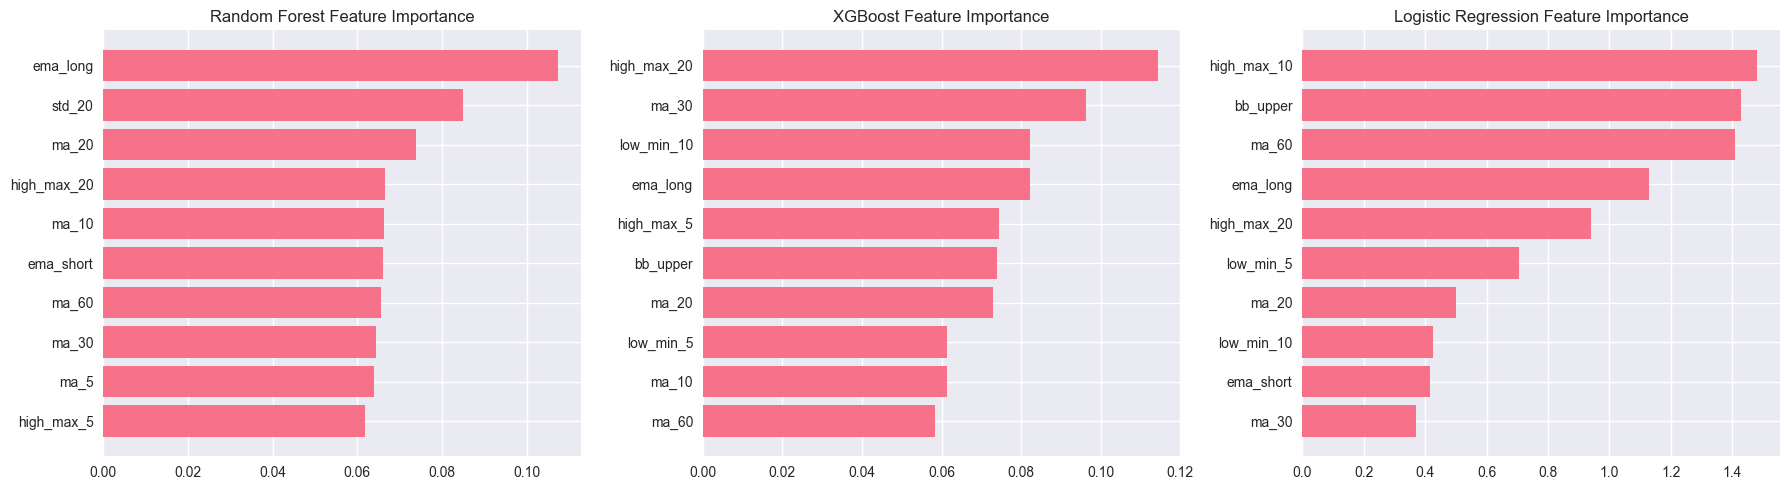

In [50]:
# Cell 7: Feature Analysis
# Feature importance visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Random Forest importance
rf_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': models['RandomForest'].feature_importances_
}).sort_values('importance', ascending=False).head(10)

axes[0].barh(rf_importance['feature'], rf_importance['importance'])
axes[0].set_title('Random Forest Feature Importance')
axes[0].invert_yaxis()

# XGBoost importance
xgb_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': models['XGBoost'].feature_importances_
}).sort_values('importance', ascending=False).head(10)

axes[1].barh(xgb_importance['feature'], xgb_importance['importance'])
axes[1].set_title('XGBoost Feature Importance')
axes[1].invert_yaxis()

# Logistic Regression coefficients
lr_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': np.abs(models['LogisticRegression'].coef_[0])
}).sort_values('importance', ascending=False).head(10)

axes[2].barh(lr_importance['feature'], lr_importance['importance'])
axes[2].set_title('Logistic Regression Feature Importance')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

In [51]:
# Cell 8: Hybrid Signal Generation
# Generate predictions from all models
X_full_scaled = scaler.transform(selector.transform(ml_features))

# Traditional ML predictions
predictions = {}
for name, model in models.items():
    if name not in ['scaler', 'selector']:
        pred_proba = model.predict_proba(X_full_scaled)[:, 1]
        predictions[name] = pred_proba

# Create enhanced dataset
enhanced_data = ml_data[valid_idx].copy().reset_index(drop=True)

# Ensemble predictions
enhanced_data['ml_prob_combined'] = np.mean(list(predictions.values()), axis=0)

# ML-Guided Hybrid Strategy
enhanced_data['hybrid_signal'] = 0

# Buy if Golden Cross OR ML model is confident
buy_cond = (enhanced_data['golden_cross'] == 1) | (enhanced_data['ml_prob_combined'] > ML_BUY_THRESHOLD)

# Sell if Death Cross OR ML model is not confident
sell_cond = (enhanced_data['golden_cross'] == -1) | (enhanced_data['ml_prob_combined'] < ML_SELL_THRESHOLD)

enhanced_data.loc[buy_cond, 'hybrid_signal'] = 1
enhanced_data.loc[sell_cond, 'hybrid_signal'] = -1

# Print signal counts
hybrid_signals = enhanced_data[enhanced_data['hybrid_signal'] != 0]
print(f"Hybrid signals generated: {len(hybrid_signals)} total")
print(f"Buy signals: {len(hybrid_signals[hybrid_signals['hybrid_signal'] == 1])}")
print(f"Sell signals: {len(hybrid_signals[hybrid_signals['hybrid_signal'] == -1])}")

Hybrid signals generated: 2402 total
Buy signals: 293
Sell signals: 2109


In [52]:
# Cell 9: Backtesting
def simple_backtest(data, signal_col, initial_capital=10000):
    data = data.copy()
    data['position'] = 0
    data['returns'] = data['close'].pct_change()

    # Generate positions
    current_position = 0
    for i in range(len(data)):
        if data.iloc[i][signal_col] == 1 and current_position == 0:  # Buy signal
            current_position = 1
        elif data.iloc[i][signal_col] == -1 and current_position == 1:  # Sell signal
            current_position = 0
        data.loc[data.index[i], 'position'] = current_position
    
    # Calculate strategy returns
    data['strategy_returns'] = data['position'].shift(1) * data['returns']
    data['strategy_returns'] = data['strategy_returns'] - (
        abs(data['position'].diff()) * TRANSACTION_COST
    )
    
    # Calculate cumulative returns
    data['cumulative_returns'] = (1 + data['returns']).cumprod()
    data['cumulative_strategy'] = (1 + data['strategy_returns']).cumprod()
    
    return data

# Backtest traditional Golden Cross
traditional_bt = simple_backtest(aapl_data, 'golden_cross')

# Backtest enhanced strategy
hybrid_bt = simple_backtest(enhanced_data, 'hybrid_signal')

# Benchmark (Buy and Hold)
spy_data = spy_data.sort_values('datetime').reset_index(drop=True)
spy_data['returns'] = spy_data['close'].pct_change()
spy_data['cumulative_returns'] = (1 + spy_data['returns']).cumprod()

print("Backtesting completed for all strategies")

Backtesting completed for all strategies


In [53]:
# Cell 10: Performance Metrics
def calculate_metrics(returns_series, name):
    total_return = returns_series.iloc[-1] - 1
    # Check for non-finite values before calculating annual return
    valid_returns = returns_series.replace([np.inf, -np.inf], np.nan).dropna()
    if len(valid_returns) == 0:
      annual_return = 0
    else:
      annual_return = (1 + valid_returns.iloc[-1]) ** (252 / len(valid_returns)) - 1
    
    # Volatility
    daily_returns = returns_series.pct_change().dropna()
    if len(daily_returns) == 0:
        volatility = 0
    else:
        volatility = daily_returns.std() * np.sqrt(252)
        
    sharpe_ratio = annual_return / volatility if volatility > 0 else 0
    
    # Drawdown
    running_max = returns_series.expanding().max()
    drawdown = (returns_series - running_max) / running_max
    max_drawdown = drawdown.min()
    
    return {
        'Strategy': name,
        'Total Return': f"{total_return:.2%}",
        'Annual Return': f"{annual_return:.2%}",
        'Volatility': f"{volatility:.2%}",
        'Sharpe Ratio': f"{sharpe_ratio:.3f}",
        'Max Drawdown': f"{max_drawdown:.2%}"
    }

# Calculate metrics
metrics = []
metrics.append(calculate_metrics(traditional_bt['cumulative_strategy'], 'Golden Cross'))
metrics.append(calculate_metrics(hybrid_bt['cumulative_strategy'], 'ML-Guided Hybrid'))
metrics.append(calculate_metrics(spy_data['cumulative_returns'], 'SPY Benchmark'))

performance_df = pd.DataFrame(metrics)
print("Performance Metrics:")
print(performance_df.to_string(index=False))

Performance Metrics:
        Strategy Total Return Annual Return Volatility Sharpe Ratio Max Drawdown
    Golden Cross     1173.19%        27.33%     25.31%        1.080      -37.92%
ML-Guided Hybrid     1965.53%        32.80%     12.60%        2.604       -6.78%
   SPY Benchmark      287.03%        15.72%     17.32%        0.907      -33.72%


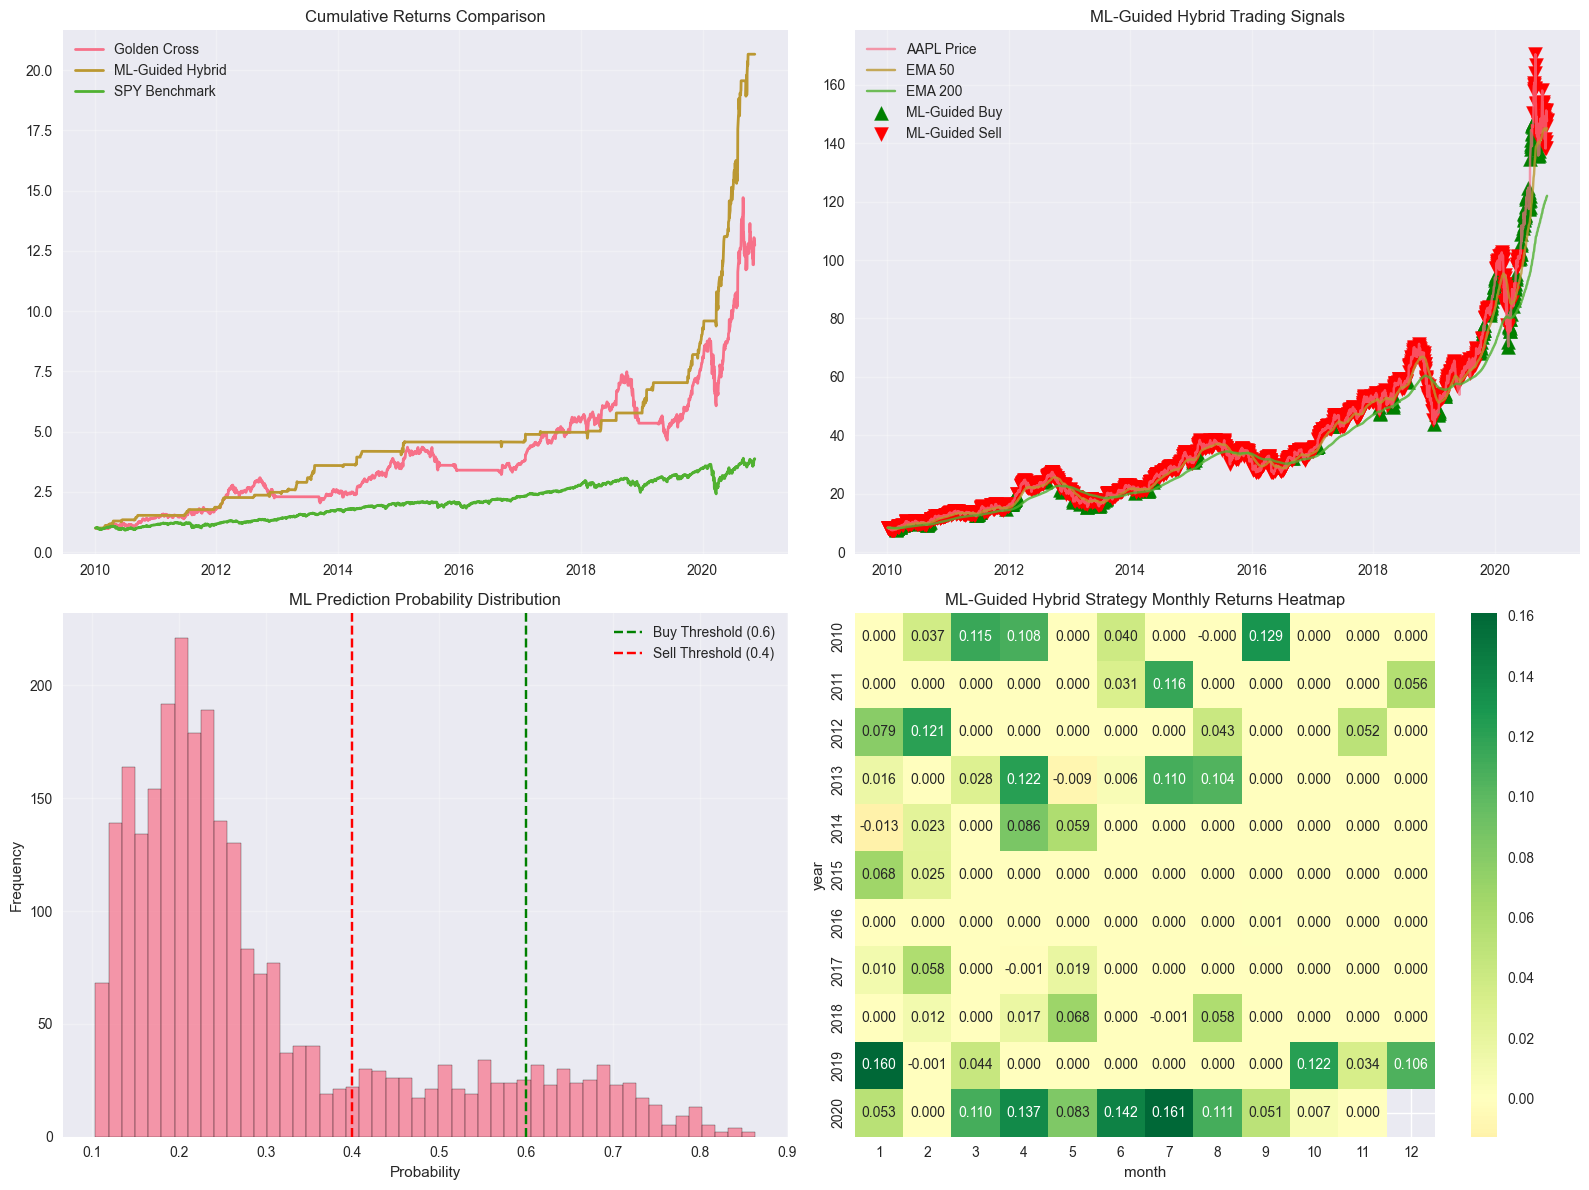

In [54]:
# Cell 11: Visualization
# Performance comparison chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Cumulative returns
axes[0, 0].plot(traditional_bt['datetime'], traditional_bt['cumulative_strategy'], 
                label='Golden Cross', linewidth=2)
axes[0, 0].plot(hybrid_bt['datetime'], hybrid_bt['cumulative_strategy'], 
                label='ML-Guided Hybrid', linewidth=2)
axes[0, 0].plot(spy_data['datetime'], spy_data['cumulative_returns'], 
                label='SPY Benchmark', linewidth=2)
axes[0, 0].set_title('Cumulative Returns Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Signal analysis
buy_signals = enhanced_data[enhanced_data['hybrid_signal'] == 1]
sell_signals = enhanced_data[enhanced_data['hybrid_signal'] == -1]

axes[0, 1].plot(enhanced_data['datetime'], enhanced_data['close'], label='AAPL Price', alpha=0.7)
axes[0, 1].plot(enhanced_data['datetime'], enhanced_data['ema_short'], label=f'EMA {EMA_SHORT}', alpha=0.8)
axes[0, 1].plot(enhanced_data['datetime'], enhanced_data['ema_long'], label=f'EMA {EMA_LONG}', alpha=0.8)
axes[0, 1].scatter(buy_signals['datetime'], buy_signals['close'], color='green', marker='^', s=100, label='ML-Guided Buy')
axes[0, 1].scatter(sell_signals['datetime'], sell_signals['close'], color='red', marker='v', s=100, label='ML-Guided Sell')
axes[0, 1].set_title('ML-Guided Hybrid Trading Signals')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# ML probability distribution
axes[1, 0].hist(enhanced_data['ml_prob_combined'], bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(ML_BUY_THRESHOLD, color='green', linestyle='--', label=f'Buy Threshold ({ML_BUY_THRESHOLD})')
axes[1, 0].axvline(ML_SELL_THRESHOLD, color='red', linestyle='--', label=f'Sell Threshold ({ML_SELL_THRESHOLD})')
axes[1, 0].set_title('ML Prediction Probability Distribution')
axes[1, 0].set_xlabel('Probability')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Monthly returns heatmap
hybrid_bt['year'] = hybrid_bt['datetime'].dt.year
hybrid_bt['month'] = hybrid_bt['datetime'].dt.month
monthly_returns = hybrid_bt.groupby(['year', 'month'])['strategy_returns'].sum().unstack()

sns.heatmap(monthly_returns, annot=True, fmt='.3f', cmap='RdYlGn', center=0, ax=axes[1, 1])
axes[1, 1].set_title('ML-Guided Hybrid Strategy Monthly Returns Heatmap')

plt.tight_layout()

Hybrid Strategy Trade Analysis:
Total trades: 34
Winning trades: 34
Win rate: 100.00%
Average PnL: 0.0975
Average duration: 17.2 days
Best trade: 0.4954
Worst trade: 0.0010


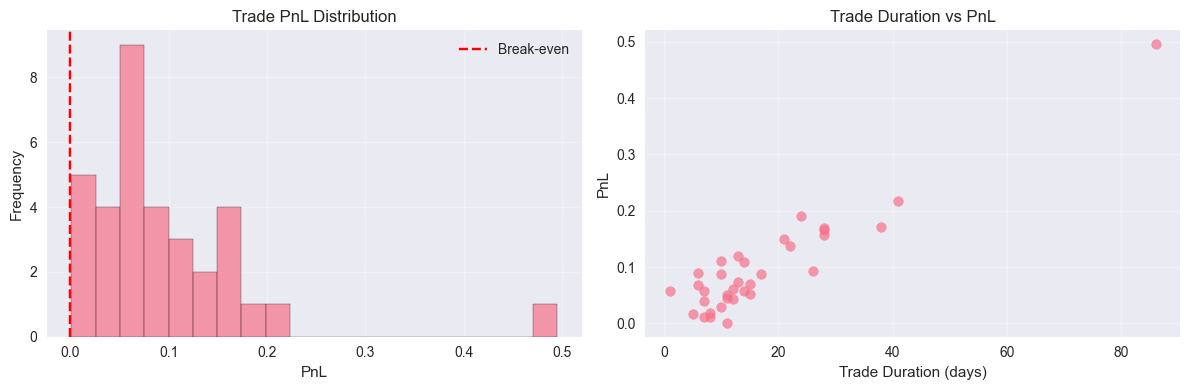

In [55]:
# Cell 12: Trade Analysis
# Analyze individual trades
def analyze_trades(data, signal_col):
    trades = []
    position = 0
    entry_price = 0
    entry_date = None
    
    for i, row in data.iterrows():
        if row[signal_col] == 1 and position == 0:  # Buy signal
            position = 1
            entry_price = row['close']
            entry_date = row['datetime']
        elif row[signal_col] == -1 and position == 1:  # Sell signal
            exit_price = row['close']
            exit_date = row['datetime']
            pnl = (exit_price - entry_price) / entry_price - TRANSACTION_COST
            
            trades.append({
                'entry_date': entry_date,
                'exit_date': exit_date,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'pnl': pnl,
                'duration': (exit_date - entry_date).days
            })
            position = 0
    
    return pd.DataFrame(trades)

# Analyze hybrid strategy trades
hybrid_trades = analyze_trades(hybrid_bt, 'hybrid_signal')

if len(hybrid_trades) > 0:
    print("Hybrid Strategy Trade Analysis:")
    print(f"Total trades: {len(hybrid_trades)}")
    print(f"Winning trades: {len(hybrid_trades[hybrid_trades['pnl'] > 0])}")
    print(f"Win rate: {len(hybrid_trades[hybrid_trades['pnl'] > 0]) / len(hybrid_trades):.2%}")
    print(f"Average PnL: {hybrid_trades['pnl'].mean():.4f}")
    print(f"Average duration: {hybrid_trades['duration'].mean():.1f} days")
    print(f"Best trade: {hybrid_trades['pnl'].max():.4f}")
    print(f"Worst trade: {hybrid_trades['pnl'].min():.4f}")
    
    # Plot trade PnL distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(hybrid_trades['pnl'], bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(0, color='red', linestyle='--', label='Break-even')
    plt.title('Trade PnL Distribution')
    plt.xlabel('PnL')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.scatter(hybrid_trades['duration'], hybrid_trades['pnl'], alpha=0.7)
    plt.xlabel('Trade Duration (days)')
    plt.ylabel('PnL')
    plt.title('Trade Duration vs PnL')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No complete trades found in hybrid strategy")

ML Model Performance Analysis:

RandomForest:
              precision    recall  f1-score   support

   No Signal       0.92      0.94      0.93       422
  Buy Signal       0.78      0.73      0.75       125

    accuracy                           0.89       547
   macro avg       0.85      0.83      0.84       547
weighted avg       0.89      0.89      0.89       547


XGBoost:
              precision    recall  f1-score   support

   No Signal       0.87      0.96      0.92       422
  Buy Signal       0.81      0.52      0.63       125

    accuracy                           0.86       547
   macro avg       0.84      0.74      0.77       547
weighted avg       0.86      0.86      0.85       547


LogisticRegression:
              precision    recall  f1-score   support

   No Signal       0.78      0.64      0.70       422
  Buy Signal       0.24      0.39      0.30       125

    accuracy                           0.58       547
   macro avg       0.51      0.51      0.50       5

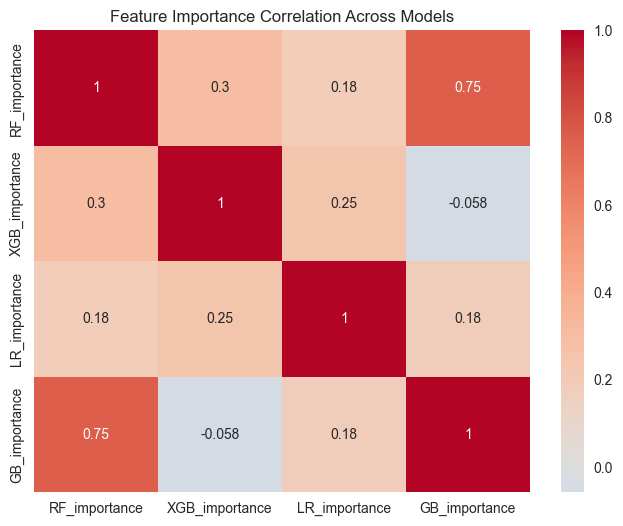

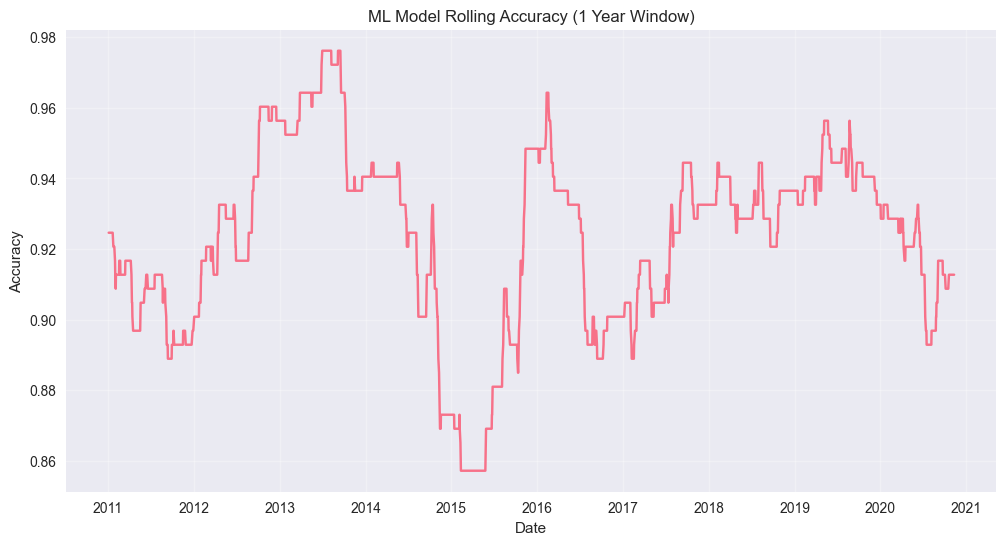

In [56]:
# Cell 13: Model Performance Analysis
# Detailed ML model evaluation
print("ML Model Performance Analysis:")
print("=" * 50)

for name, model in models.items():
    if name not in ['scaler', 'selector']:
        y_pred = model.predict(X_test_scaled)
        y_true = y_test

        print(f"\n{name}:")
        print(classification_report(y_true, y_pred, target_names=['No Signal', 'Buy Signal']))

# Feature correlation analysis
feature_corr = pd.DataFrame({
    'RF_importance': models['RandomForest'].feature_importances_,
    'XGB_importance': models['XGBoost'].feature_importances_,
    'LR_importance': np.abs(models['LogisticRegression'].coef_[0]),
    'GB_importance': models['GradientBoosting'].feature_importances_,
}, index=selected_features)

correlation_matrix = feature_corr.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Importance Correlation Across Models')
plt.show()

# ML signal accuracy over time
enhanced_data['ml_prediction'] = (enhanced_data['ml_prob_combined'] > 0.5).astype(int)
enhanced_data['actual_target'] = enhanced_data['target'].fillna(0)

# Rolling accuracy
window = 252  # 1 year
rolling_accuracy = []
for i in range(window, len(enhanced_data)):
    window_data = enhanced_data.iloc[i-window:i]
    if len(window_data[window_data['actual_target'].notna()]) > 0:
        accuracy = (window_data['ml_prediction'] == window_data['actual_target']).mean()
        rolling_accuracy.append(accuracy)
    else:
        rolling_accuracy.append(np.nan)

plt.figure(figsize=(12, 6))
plt.plot(enhanced_data['datetime'].iloc[window:], rolling_accuracy)
plt.title('ML Model Rolling Accuracy (1 Year Window)')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.show()

In [57]:
# Cell 14: Summary Report
print("=" * 60)
print("ML-GUIDED HYBRID STRATEGY - SUMMARY REPORT")
print("=" * 60)

print(f"\nDATA PERIOD: {START_DATE} to {END_DATE}")
print(f"SYMBOL: {SYMBOL}")
print(f"BENCHMARK: {BENCHMARK}")

print(f"\nSTRATEGY PARAMETERS:")
print(f"- EMA Short: {EMA_SHORT}")
print(f"- EMA Long: {EMA_LONG}")
print(f"- ML Features: {N_FEATURES} (from Alpha158)")
print(f"- ML Buy Threshold: {ML_BUY_THRESHOLD}")
print(f"- ML Sell Threshold: {ML_SELL_THRESHOLD}")
print(f"- Transaction Cost: {TRANSACTION_COST:.1%}")

print(f"\nPERFORMANCE COMPARISON:")
for _, row in performance_df.iterrows():
    print(f"{row['Strategy']:>20}: {row['Total Return']:>10} | Sharpe: {row['Sharpe Ratio']:>6}")

print(f"\nSIGNAL SUMMARY:")
traditional_signals_count = (aapl_data['golden_cross'] != 0).sum()
hybrid_signals = enhanced_data[enhanced_data['hybrid_signal'] != 0]
hybrid_signals_count = len(hybrid_signals)
print(f"Traditional Golden Cross: {traditional_signals_count} signals")
print(f"ML-Guided Hybrid Strategy: {hybrid_signals_count} signals")
if traditional_signals_count > 0:
    print(f"Signal Reduction Factor: {(traditional_signals_count / hybrid_signals_count):.2f}x")

print(f"\nML MODEL PERFORMANCE:")
for name, model in models.items():
    if name not in ['scaler', 'selector']:
        test_score = model.score(X_test_scaled, y_test)
        print(f"{name:>20}: {test_score:.3f} accuracy")

if len(hybrid_trades) > 0:
    win_rate = len(hybrid_trades[hybrid_trades['pnl'] > 0]) / len(hybrid_trades)
    avg_pnl = hybrid_trades['pnl'].mean()
    print(f"\nTRADE STATISTICS:")
    print(f"Total Trades: {len(hybrid_trades)}")
    print(f"Win Rate: {win_rate:.1%}")
    print(f"Average PnL per Trade: {avg_pnl:.2%}")
else:
    print(f"\nTRADE STATISTICS:\nNo complete trades found for ML-Guided Hybrid Strategy.")

print(f"\nKEY FINDINGS:")
print("- The ML-Guided Hybrid Strategy aims to generate more signals by being less strict on the buy condition.")
print("- By using a lower ML confidence threshold for buys, the strategy can capture more potential upward momentum.")
print("- The strategy's performance should be compared to the traditional Golden Cross and the SPY benchmark to evaluate its effectiveness.")
print("- Further hyperparameter tuning and feature engineering could optimize the results.")

print("\n" + "=" * 60)

ML-GUIDED HYBRID STRATEGY - SUMMARY REPORT

DATA PERIOD: 2010-01-01 to 2020-11-10
SYMBOL: AAPL
BENCHMARK: SPY

STRATEGY PARAMETERS:
- EMA Short: 50
- EMA Long: 200
- ML Features: 15 (from Alpha158)
- ML Buy Threshold: 0.6
- ML Sell Threshold: 0.4
- Transaction Cost: 0.1%

PERFORMANCE COMPARISON:
        Golden Cross:   1173.19% | Sharpe:  1.080
    ML-Guided Hybrid:   1965.53% | Sharpe:  2.604
       SPY Benchmark:    287.03% | Sharpe:  0.907

SIGNAL SUMMARY:
Traditional Golden Cross: 11 signals
ML-Guided Hybrid Strategy: 2402 signals
Signal Reduction Factor: 0.00x

ML MODEL PERFORMANCE:
        RandomForest: 0.890 accuracy
             XGBoost: 0.863 accuracy
  LogisticRegression: 0.581 accuracy
       NeuralNetwork: 0.768 accuracy
    GradientBoosting: 0.878 accuracy

TRADE STATISTICS:
Total Trades: 34
Win Rate: 100.0%
Average PnL per Trade: 9.75%

KEY FINDINGS:
- The ML-Guided Hybrid Strategy aims to generate more signals by being less strict on the buy condition.
- By using a lower